# Drone Detection using Computer Vision Models

In [ ]:
!pip install -q kaggle

In [ ]:
import os
import re
import shutil
import torch
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme()

## Load Dataset

In [ ]:
!mkdir ~/.kaggle

In [ ]:
# Upload Kaggle API key JSON file
from google.colab import files

files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d cybersimar08/drone-detection

Dataset URL: https://www.kaggle.com/datasets/cybersimar08/drone-detection
License(s): CC0-1.0
 96% 481M/499M [00:08<00:00, 56.9MB/s]
100% 499M/499M [00:08<00:00, 64.0MB/s]


In [ ]:
# Unzip dataset file
import zipfile
with zipfile.ZipFile('drone-detection.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Ensure you are in the "./content" directory
!pwd

/content


In [ ]:
os.listdir("./drone-detection-new.v5-new-train.yolov8/train/labels")[:5]

['V_DRONE_027137_083_png.rf.26c1e10c772629b33bc03876f164db60.txt',
 'V_HELICOPTER_011235_008_png.rf.98d74f209a3b36102ebde2495aef758c.txt',
 'V_AIRPLANE_0099_023_png.rf.22a6ff1e809906f2e286425dee0fb6be.txt',
 'V_HELICOPTER_045269_034_png.rf.0d24c27daa91ffd066b6d727c30549cd.txt',
 'V_BIRD_03998_246_png.rf.84a4e49841aa3c4300e81127f2f08c30.txt']

In [ ]:
os.listdir("./drone-detection-new.v5-new-train.yolov8/train/images")[:5]

['V_AIRPLANE_0022_182_png.rf.656e338ab285cf214e316f3f2062c98c.jpg',
 'V_BIRD_01473_211_png.rf.e30be827b9c7a92f2eebff2a18143428.jpg',
 'V_DRONE_092202_083_png.rf.643acc8a7c374396272c9b9de9266cbd.jpg',
 'V_HELICOPTER_060284_223_png.rf.b023a7c4bff9e5a5f68ea682b7d97906.jpg',
 'V_HELICOPTER_005229_218_png.rf.0c39f27ff381adc563407392f5d80816.jpg']

In [ ]:
base_path = "./drone-detection-new.v5-new-train.yolov8/train"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

# NOTE: exclude BIRD class
class_mapping = {
    0: "AIRPLANE",
    1: "DRONE",
    2: "HELICOPTER"
}

In [ ]:
def get_matching_files():
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]

    image_files = [f for f in image_files if 'BIRD' not in f]
    label_files = [f for f in label_files if 'BIRD' not in f]

    image_map = {os.path.splitext(f)[0]: f for f in image_files}
    label_map = {os.path.splitext(f)[0]: f for f in label_files}

    common_keys = set(image_map.keys()) & set(label_map.keys())

    matched_files = [(image_map[k], label_map[k]) for k in common_keys]
    return matched_files

def extract_info_from_filename(filename):
    match = re.match(r'V_([A-Z]+)_(\d+_\d+)_', filename)
    if match:
        class_name, image_id = match.groups()
        return class_name, image_id
    return None, None

def read_label_file(label_path):
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()

        boxes = []
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            boxes.append({
                'class_id': int(class_id),
                'class_name': class_mapping[int(class_id)],
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
        return boxes
    except Exception as e:
        print(f"Error reading {label_path}: {e}")
        return []

def create_dataset():
    matched_files = get_matching_files()

    data = []
    for img_file, label_file in matched_files:
        class_name, image_id = extract_info_from_filename(img_file)

        img_path = os.path.join(images_path, img_file)
        with Image.open(img_path) as img:
            img_width, img_height = img.size

        label_path = os.path.join(labels_path, label_file)
        boxes = read_label_file(label_path)

        for box in boxes:
            if box["class_name"] != class_name:
                print(f"Found mismatch between filename class and detected class: {image_id}")

            data.append({
                'image_file': img_file,
                'label_file': label_file,
                'image_id': image_id,
                'class': box['class_name'],
                'x_center': box['x_center'],
                'y_center': box['y_center'],
                'width': box['width'],
                'height': box['height'],
                'image_width': img_width,
                'image_height': img_height,
                'image_path': img_path,
                'label_path': label_path
            })

    return pd.DataFrame(data)

## Exploratory Data Analysis

In [ ]:
df = create_dataset()

In [ ]:
print("Dataset Summary:")
print(f"Total number of objects: {len(df)}")
print(f"Total number of unique images: {df['image_file'].nunique()}")

print("\nClass distribution:")
print(df['class'].value_counts())

print("\nImage dimensions summary:")
print(df[['image_width', 'image_height']].describe())

Dataset Summary:
Total number of objects: 8997
Total number of unique images: 8818

Class distribution:
class
DRONE         4349
HELICOPTER    2374
AIRPLANE      2274
Name: count, dtype: int64

Image dimensions summary:
       image_width  image_height
count       8997.0        8997.0
mean         640.0         640.0
std            0.0           0.0
min          640.0         640.0
25%          640.0         640.0
50%          640.0         640.0
75%          640.0         640.0
max          640.0         640.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8997 entries, 0 to 8996
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_file    8997 non-null   object 
 1   label_file    8997 non-null   object 
 2   image_id      8997 non-null   object 
 3   class         8997 non-null   object 
 4   x_center      8997 non-null   float64
 5   y_center      8997 non-null   float64
 6   width         8997 non-null   float64
 7   height        8997 non-null   float64
 8   image_width   8997 non-null   int64  
 9   image_height  8997 non-null   int64  
 10  image_path    8997 non-null   object 
 11  label_path    8997 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 843.6+ KB


In [ ]:
df.head()

,image_file,label_file,image_id,class,x_center,y_center,width,height,image_width,image_height,image_path,label_path
0,V_HELICOPTER_045269_050_png.rf.8206f9003e4e9bb...,V_HELICOPTER_045269_050_png.rf.8206f9003e4e9bb...,045269_050,HELICOPTER,0.501563,0.398438,0.107813,0.116406,640,640,./drone-detection-new.v5-new-train.yolov8/trai...,./drone-detection-new.v5-new-train.yolov8/trai...
1,V_HELICOPTER_046270_193_png.rf.3eb62e2671582a4...,V_HELICOPTER_046270_193_png.rf.3eb62e2671582a4...,046270_193,HELICOPTER,0.655469,0.532031,0.097656,0.100000,640,640,./drone-detection-new.v5-new-train.yolov8/trai...,./drone-detection-new.v5-new-train.yolov8/trai...
2,V_DRONE_009119_156_png.rf.2b6a20ebaa68ab1c008a...,V_DRONE_009119_156_png.rf.2b6a20ebaa68ab1c008a...,009119_156,DRONE,0.482812,0.369531,0.039844,0.038281,640,640,./drone-detection-new.v5-new-train.yolov8/trai...,./drone-detection-new.v5-new-train.yolov8/trai...
3,V_DRONE_086196_274_png.rf.b6884135f8c4ef50f235...,V_DRONE_086196_274_png.rf.b6884135f8c4ef50f235...,086196_274,DRONE,0.665625,0.381250,0.090625,0.090625,640,640,./drone-detection-new.v5-new-train.yolov8/trai...,./drone-detection-new.v5-new-train.yolov8/trai...
4,V_AIRPLANE_03939_244_png.rf.2c6ed14b151593099c...,V_AIRPLANE_03939_244_png.rf.2c6ed14b151593099c...,03939_244,AIRPLANE,0.589063,0.523438,0.148438,0.100000,640,640,./drone-detection-new.v5-new-train.yolov8/trai...,./drone-detection-new.v5-new-train.yolov8/trai...


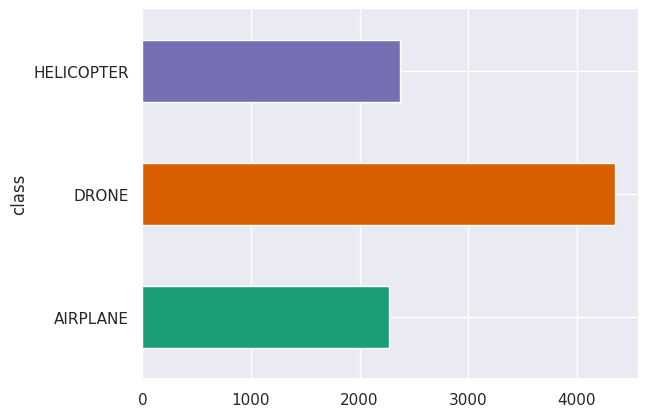

In [ ]:
df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

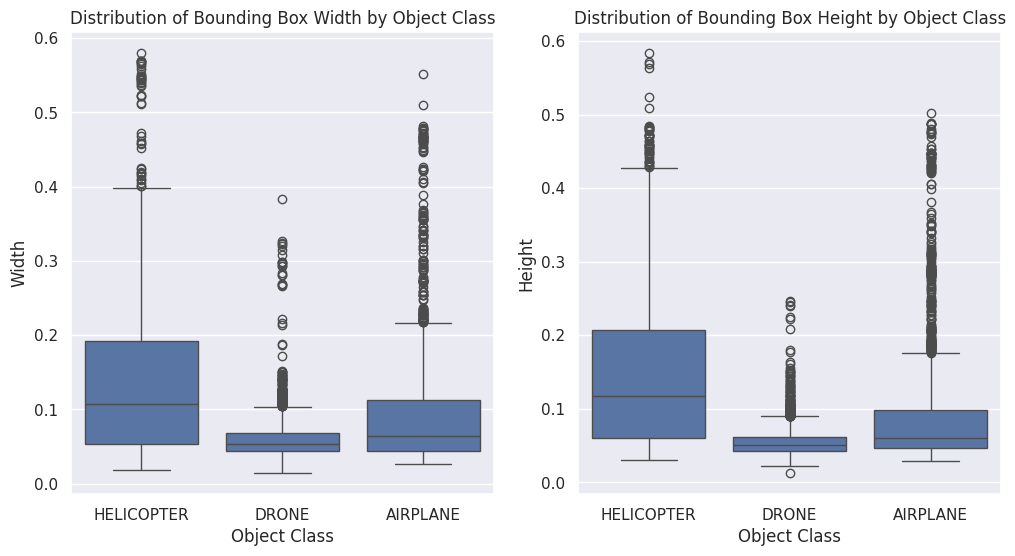

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='class', y='width', data=df)
plt.title('Distribution of Bounding Box Width by Object Class')
plt.xlabel('Object Class')
plt.ylabel('Width')

plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='height', data=df)
plt.title('Distribution of Bounding Box Height by Object Class')
plt.xlabel('Object Class')
_ = plt.ylabel('Height')

## Simple CNN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DroneDetectionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        self.unique_images = self.df.groupby('image_path').agg({
            'x_center': list,
            'y_center': list,
            'width': list,
            'height': list,
            'class': list
        }).reset_index()

    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, idx):
        row = self.unique_images.iloc[idx]

        # Load and transform image
        image = Image.open(row['image_path'])
        if self.transform:
            image = self.transform(image)

        # Create target tensor: [class_id, x_center, y_center, width, height]
        num_boxes = len(row['x_center'])
        boxes = torch.zeros((10, 5))  # Fixed size for 10 boxes max
        boxes[:, 0] = -1  # Initialize with -1 for empty boxes

        for i in range(min(num_boxes, 10)):  # Limit to 10 boxes
            # Convert class name to ID
            class_name = row['class'][i]
            class_id = 0  # AIRPLANE
            if class_name == 'DRONE':
                class_id = 1
            elif class_name == 'HELICOPTER':
                class_id = 2

            boxes[i] = torch.tensor([
                float(class_id),
                row['x_center'][i],
                row['y_center'][i],
                row['width'][i],
                row['height'][i]
            ])

        return image, boxes

class SimpleDetectionCNN(nn.Module):
    def __init__(self, num_classes=3, max_objects=10):
        super(SimpleDetectionCNN, self).__init__()
        self.max_objects = max_objects
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Output: [max_objects, num_classes + 4] where 4 = [x, y, w, h]
            nn.Linear(512, max_objects * (num_classes + 4))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        # Reshape to [batch_size, max_objects, num_classes + 4]
        return x.view(-1, self.max_objects, self.num_classes + 4)

def detection_loss(pred, target):
    batch_size = pred.size(0)
    max_objects = pred.size(1)
    num_classes = pred.size(2) - 4

    # Split prediction into classification and regression
    pred_cls = pred[..., :num_classes]  # [batch, max_objects, num_classes]
    pred_reg = pred[..., num_classes:]  # [batch, max_objects, 4]

    # Get valid mask (where target class != -1)
    valid_mask = target[..., 0] != -1  # [batch, max_objects]

    cls_loss = 0
    reg_loss = 0
    total_valid = valid_mask.sum()

    if total_valid > 0:
        valid_pred_cls = pred_cls[valid_mask]
        valid_target_cls = target[valid_mask][:, 0].long()
        cls_loss = nn.CrossEntropyLoss()(valid_pred_cls, valid_target_cls)

        valid_pred_reg = pred_reg[valid_mask]
        valid_target_reg = target[valid_mask][:, 1:]
        reg_loss = nn.MSELoss()(valid_pred_reg, valid_target_reg)

    total_loss = cls_loss + reg_loss
    return total_loss

def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = detection_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                val_loss += detection_loss(outputs, targets).item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch+1} complete - Avg Train Loss: {avg_train_loss:.4f}, '
              f'Avg Val Loss: {avg_val_loss:.4f}')

def prepare_and_train():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    dataset = DroneDetectionDataset(df, transform=transform)

    # Split into train/validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize model
    model = SimpleDetectionCNN()

    # Train model
    train_model(model, train_loader, val_loader)

    return model

# Add visualization function
def visualize_predictions(model, dataset, idx=0):
    import matplotlib.patches as patches

    model.eval()
    image, target = dataset[idx]

    # Get prediction
    with torch.no_grad():
        pred = model(image.unsqueeze(0))

    # Convert image for display
    img_display = image.permute(1, 2, 0).numpy()
    img_display = (img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Ground truth
    ax1.imshow(img_display)
    ax1.set_title('Ground Truth')
    for box in target:
        if box[0] == -1:  # Skip empty boxes
            continue
        x, y, w, h = box[1:].numpy()
        rect = patches.Rectangle(
            (x - w/2, y - h/2), w, h,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax1.add_patch(rect)

    # Predictions
    ax2.imshow(img_display)
    ax2.set_title('Predictions')
    pred = pred[0]  # Remove batch dimension
    for box_pred in pred:
        class_scores = box_pred[:3]  # First 3 values are class scores
        box_coords = box_pred[3:]    # Last 4 values are box coordinates

        if class_scores.max() > 0.5:  # Confidence threshold
            x, y, w, h = box_coords.numpy()
            rect = patches.Rectangle(
                (x - w/2, y - h/2), w, h,
                linewidth=2, edgecolor='b', facecolor='none'
            )
            ax2.add_patch(rect)

    plt.show()

# Train the model
model = prepare_and_train()

Using device: cuda
Epoch 1/10, Batch 0/441, Loss: 1.2722
Epoch 1/10, Batch 10/441, Loss: 0.7844
Epoch 1/10, Batch 20/441, Loss: 1.1655
Epoch 1/10, Batch 30/441, Loss: 0.8840
Epoch 1/10, Batch 40/441, Loss: 0.9222
Epoch 1/10, Batch 50/441, Loss: 0.5458
Epoch 1/10, Batch 60/441, Loss: 0.6901
Epoch 1/10, Batch 70/441, Loss: 0.6408
Epoch 1/10, Batch 80/441, Loss: 1.1127
Epoch 1/10, Batch 90/441, Loss: 0.6764
Epoch 1/10, Batch 100/441, Loss: 0.7147
Epoch 1/10, Batch 110/441, Loss: 0.6549
Epoch 1/10, Batch 120/441, Loss: 0.6650
Epoch 1/10, Batch 130/441, Loss: 0.6502
Epoch 1/10, Batch 140/441, Loss: 0.6661
Epoch 1/10, Batch 150/441, Loss: 0.3900
Epoch 1/10, Batch 160/441, Loss: 0.6654
Epoch 1/10, Batch 170/441, Loss: 0.4687
Epoch 1/10, Batch 180/441, Loss: 0.5861
Epoch 1/10, Batch 190/441, Loss: 0.4739
Epoch 1/10, Batch 200/441, Loss: 0.4270
Epoch 1/10, Batch 210/441, Loss: 0.3470
Epoch 1/10, Batch 220/441, Loss: 0.4854
Epoch 1/10, Batch 230/441, Loss: 0.4523
Epoch 1/10, Batch 240/441, Loss:

## VGG16 Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class VGG16DetectionModel(nn.Module):
    def __init__(self, num_classes=3, max_objects=10, pretrained=True):
        super(VGG16DetectionModel, self).__init__()
        self.max_objects = max_objects
        self.num_classes = num_classes

        vgg16 = models.vgg16(pretrained=pretrained)
        self.features = vgg16.features

        # Freeze early layers
        for param in list(self.features.parameters())[:-8]:
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),  # VGG16 original uses 7x7
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, max_objects * (num_classes + 4))  # classes + bbox coordinates
        )

        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1, self.max_objects, self.num_classes + 4)

def train_vgg16_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    params_to_update = [
        {'params': model.features.parameters(), 'lr': 0.0001},
        {'params': model.classifier.parameters(), 'lr': 0.001}
    ]

    optimizer = torch.optim.Adam(params_to_update)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = detection_loss(outputs, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                outputs = model(images)
                val_loss += detection_loss(outputs, targets).item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch+1} complete - Avg Train Loss: {avg_train_loss:.4f}, '
              f'Avg Val Loss: {avg_val_loss:.4f}')

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, 'best_vgg16_model.pth')

def prepare_and_train_vgg16():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                           std=[0.229, 0.224, 0.225])
    ])

    dataset = DroneDetectionDataset(df, transform=transform)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    model = VGG16DetectionModel(pretrained=True)
    train_vgg16_model(model, train_loader, val_loader)

    return model

def load_best_model():
    model = VGG16DetectionModel(pretrained=False)
    checkpoint = torch.load('best_vgg16_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [ ]:
model = prepare_and_train_vgg16()

dataset = DroneDetectionDataset(df, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

visualize_predictions(model, dataset, idx=0)

## Feature Pyramid Networks

## Vision Transformer

## YOLOv11 Model

## ResNext Model